# Force chains in emulsion gels


## About this notebook
In this notebook we perform the analysis of the experimental data. The data are stored in the `data` folder

In [1]:
ls data

phi_p_0.8/    phi_p_1.5/    phi_p_2.0/    stressTensor/
phi_p_1.2/    phi_p_1.7/    phi_p_2.3/


Each folder contains pure `txt` files with the original data from Jun and `xyz` files that can be rendered in `Ovito` or `VMD`.

In [2]:
ls data/phi_p_0.8/

Contact_center.txt   contacts.xyz         particle_center.txt
TCC/                 coords.xyz
box.txt              inputparameters.ini


Lengthy and complex algorithms should be stored in the folder `src`

In [3]:
ls src

__pycache__/           geometry.py            merge_coord_stress.py
convert_txt2xyz.py     io.py


## Visualising the data

We first import the basic numerical and visuaisation modules. If they are missing, thhey can be install via `pip install module-name`. For example 

`pip install ipyvolume`

In [4]:
import numpy as np
import scipy as sp
import ipyvolume as ipv
import matplotlib.pyplot as plt

In [5]:
%load_ext autoreload
%autoreload 2
from src import io

In [6]:
pol = 1.2
centres = io.Centres(f"data/phi_p_{pol}/coords.xyz")
contacts = io.Contacts(f"data/phi_p_{pol}/contacts.xyz")

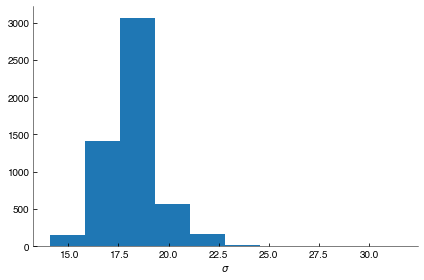

In [7]:
plt.hist(2*centres.radius); plt.xlabel('$\sigma$');

In [8]:
x, y, z = centres.unpack()
color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
ipv.scatter(x, y, z, size=centres.radius/2.5, marker="sphere", color=color)

x, y, z = contacts.unpack()
ipv.scatter(x, y, z, size=0.9, marker="sphere", color='red')
ipv.show()

## Example of analysis

We show hee how we can proceed to explore the data. For example, we get the nearest contacts for every particle centre. To do so, we fix a cutoff radius `rcut` for our search. 

In [9]:
from scipy.spatial import cKDTree

rcut = centres.radius.mean()*1.2
centre_tree = cKDTree(centres.coord)
contact_tree = cKDTree(contacts.coord)
centre_contacts=centre_tree.query_ball_tree(contact_tree, rcut)

By the same means, we can easily estimate the radial distribution function `g(r)`.

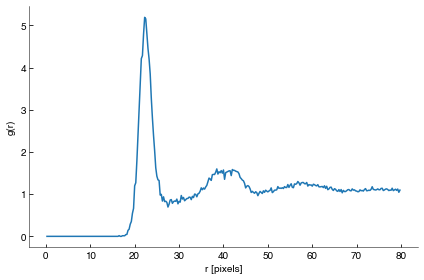

In [10]:
dr =0.25
r = np.arange(dr,80,dr)
nb = centre_tree.count_neighbors(centre_tree,r, cumulative=False)
nb[0]=0 # ignore self-distances
V = np.prod(centres.coord.ptp(axis=0))
N  = centres.coord.shape[0]
g = nb/(4*np.pi*r**2*dr)*V/(N*(N-1))
plt.plot(r,g); plt.xlabel('r [pixels]'); plt.ylabel('g(r)');

Similarly, we can compute the coordination within a larger cutoff, for example around the first minimum of `g(r)`.

In [11]:
rcut = 27
neighs=centre_tree.query_ball_tree(centre_tree,rcut)
coordination = [len(n)-1 for n in neighs]

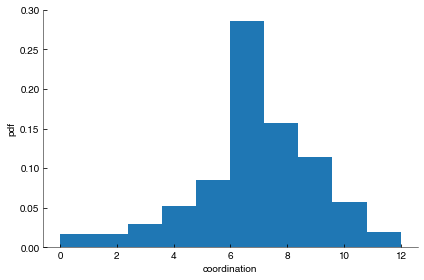

In [12]:
plt.hist(coordination, density=True); plt.xlabel('coordination');plt.ylabel('pdf');

In [13]:
centre_contacts_weights = []
num_contacts = []
for c in centre_contacts:
    w = []
    if len(c)>0:
        w=list(contacts.volume[c])
    
    num_contacts.append(len(c))
    centre_contacts_weights.append(w)

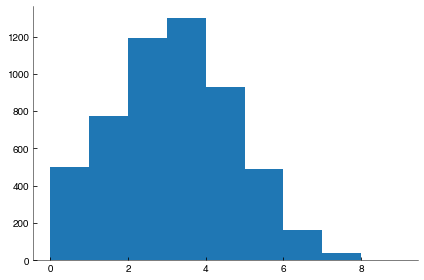

In [14]:
plt.hist(num_contacts,bins=np.arange(10));

## Network construction

We need to find common contacts to construct edges.

In [15]:
from scipy.spatial.distance import cdist

In [16]:
rcut = centres.radius.mean()*2.0
neighs = contact_tree.query_ball_tree(centre_tree,rcut)
closest = []
closest_dists = []
for i,n in enumerate(neighs):
    n = np.array(n)
#     print(i,n
    if len(n)>0:
        dists = np.linalg.norm(centres.coord[n]-contacts.coord[i], axis=1) 
#         print(n,dists,dists.argsort())
        order = dists.argsort()[:2]
        closest.append(n[order])
        closest_dists.append(dists[order])
    else:
        closest.append([])
        closest_dists.append([])

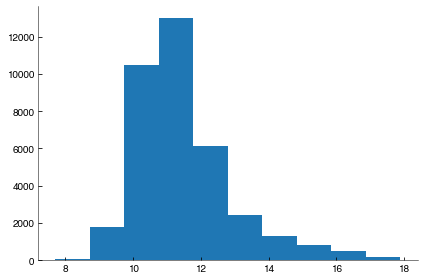

In [17]:
# check the distribution of distances between contacts and centres
dists = np.concatenate(np.array([d for d in closest_dists if len(d)>0]))
plt.hist(dists);

In [18]:
missing = [1 for n in closest if len(n)==0]
sum(missing)

0

In [19]:
closest[0]

array([5282, 1524])

In [20]:
import networkx as nx

In [21]:
G = nx.Graph()
min_vol = 180 #very important threshold: it decides how many edges form the network. Thousands of edges quickly become unmanegeable from the plotting point of view
for i,e in enumerate(closest):
    if contacts.volume[i]>min_vol: 
        G.add_edge(e[0],e[1])#,weight=contacts.volume[i])#, weight=contacts.volume[i])
G.number_of_edges()

1081

In [22]:
pos = nx.spring_layout(G)

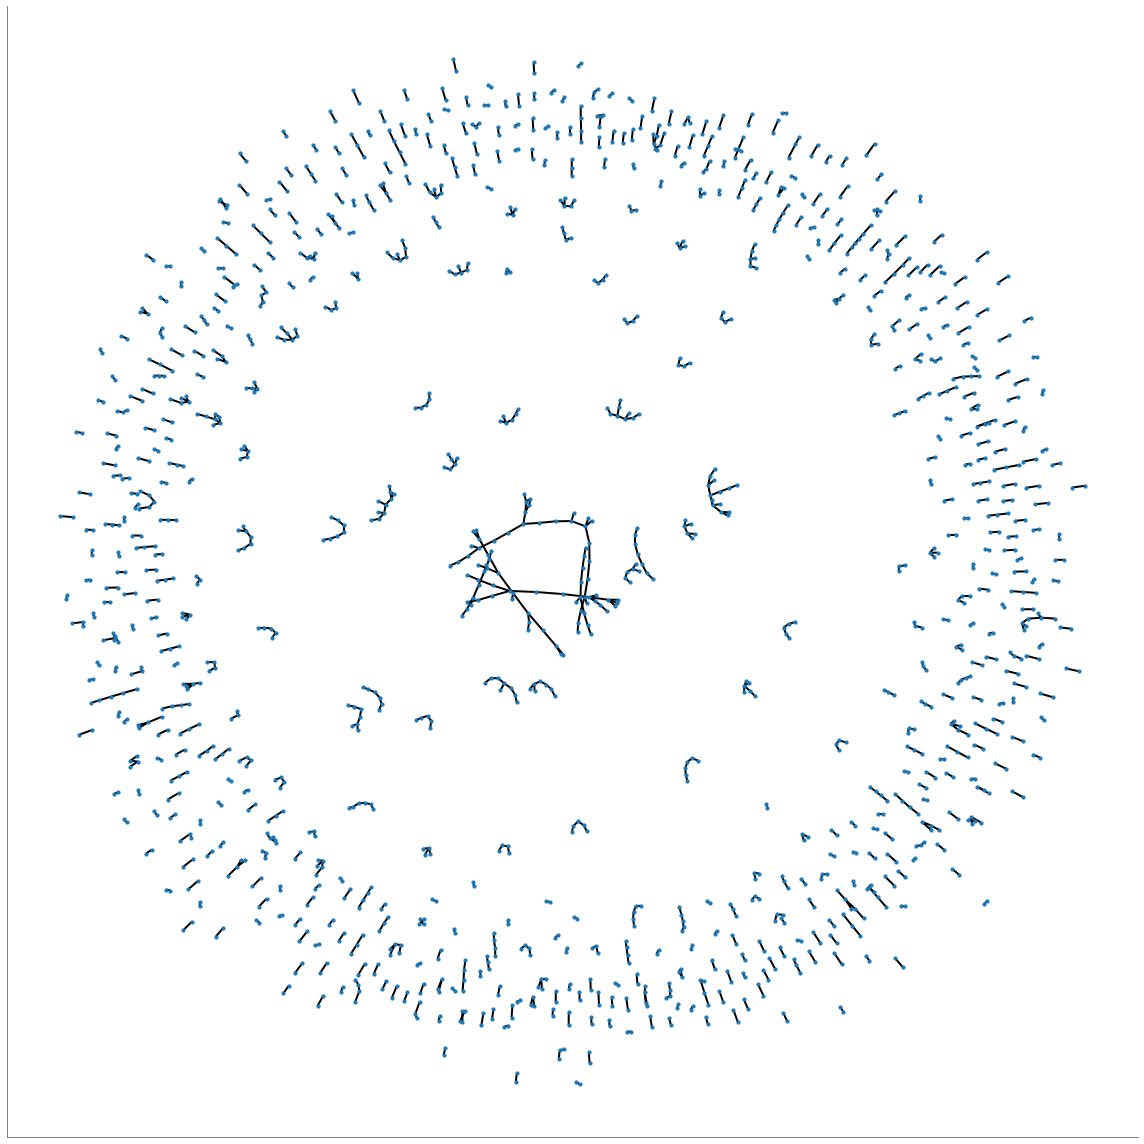

In [23]:
plt.figure(figsize=(16,16))
nx.draw_networkx(G, pos,node_size=10,with_labels=False,width=2)
# plt.xlim(-0.25,0.25)
# plt.ylim(-0.1,0.2)
plt.savefig(f"figs/{G.number_of_edges()}edges.png", dpi=300)

From the Graph we can extract many possible metrics. For example the **deegre assortativity** measures to what extent nodes with similar degrees cluster together (see Newman PRE 67, 026126 􏰒2003􏰀).

In [24]:
nx.degree_assortativity_coefficient(G)

0.1522152874853166

One can compute the **centrality**, which should simply reflect the total number fo contacts

In [25]:
centrality = nx.degree_centrality(G)

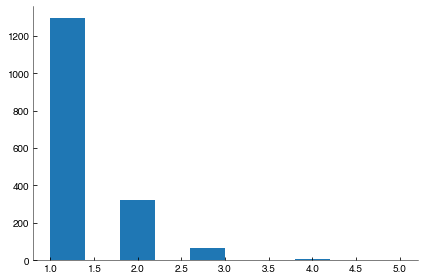

In [26]:
plt.hist(np.array(list(centrality.values()))*G.number_of_nodes());

Simple geometrical measures are also possible, such as the **number of triangles**.

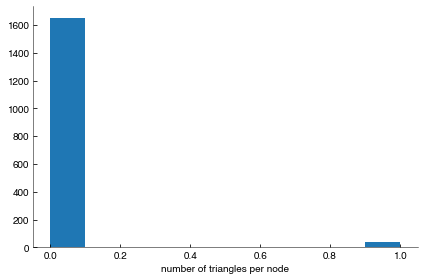

In [27]:
plt.hist(nx.triangles(G).values());
plt.xlabel("number of triangles per node");

We can for example compute the **transitivity** $T$ as
$$T=3 \frac{\# \text { triangles }}{\# \text { triads }}$$
which is $T=1$ for complete graphs (where every pair of nodes is connected by a single edge).

In [28]:
nx.transitivity(G)

0.06405693950177936

![figs/transitivity.png](figs/transitivity.png)

# Stress Tensor

The data from Jun are stored in a different sub-folder

In [29]:
ls data/stressTensor/

0.8/ 1.2/ 2.0/


In [30]:
ls data/stressTensor/0.8/

major_stress.txt   minor_stress.txt   stress_tensor.pkl  stress_trace.txt


In [31]:
import pickle
stress_path = f'data/stressTensor/{pol}/'
major = np.loadtxt(stress_path+'major_stress.txt')
minor = np.loadtxt(stress_path+'minor_stress.txt')
trace = np.loadtxt(stress_path+'stress_trace.txt')
pkl = pickle.load(open(stress_path+'stress_tensor.pkl', 'rb')) # a matrix for every particle

In [32]:
#guessing the criterion used by Jun
rcut = 28
centre_tree = cKDTree(centres.coord)
neighs=centre_tree.query_ball_tree(centre_tree,rcut)
coordination = np.array([len(n)-1 for n in neighs])
print(len(coordination[coordination>1]), len(minor))

5292 5292


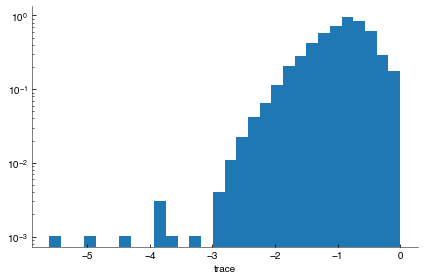

In [33]:
plt.hist(trace,bins=30, density=True);
plt.yscale('log')
plt.xlabel('trace');

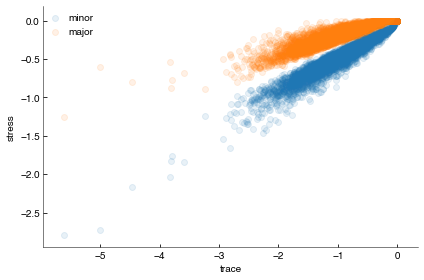

In [34]:
plt.scatter(trace,minor, alpha=0.1, label='minor')
plt.scatter(trace,major, alpha=0.1, label = 'major')
plt.xlabel('trace')
plt.ylabel('stress');
plt.legend();

Compute a weighted g(r) 

In [43]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.cluster import DBSCAN

In [35]:

def weighted_gr(threshold):
    dr =0.25
    r = np.arange(dr,80,dr)
    wcentre_tree = cKDTree(centres.coord[coordination>1])
    wnb = wcentre_tree.count_neighbors(wcentre_tree,r, cumulative=False, weights = trace<=threshold)
    wnb[0]=0 # ignore self-distances
    V = np.prod(centres.coord.ptp(axis=0))
    N  = len(trace)
    gw = wnb/(4*np.pi*r**2*dr)*V/(N*(N-1))
    plt.plot(r,g); 
    plt.plot(r,gw/gw[-1]); 

    plt.xlabel('r [pixels]'); plt.ylabel('g(r)');

interact_manual(weighted_gr, threshold=widgets.FloatSlider(min=-3, max=0, value=-1));

interactive(children=(FloatSlider(value=-1.0, description='threshold', max=0.0, min=-3.0), Button(description=…

In [88]:
def plot_clusters(threshold, rcut=28, size=5.):
    ipv.clear()

    s = trace<=threshold
    xyz = centres.coord[coordination>1][s]

    x, y, z = xyz[:,0],xyz[:,1],xyz[:,2]
    clustering = DBSCAN(eps=rcut, min_samples=1).fit(xyz)
    labels = np.unique(clustering.labels_)
    
    counts,edges= np.histogram(clustering.labels_,bins=np.arange(labels.min(), labels.max()+1))
    
    largest = edges[counts.argmax()]
    
    color_dict = {}
    for l in labels:
        color_dict[l] =  tuple(np.random.uniform(0,1, size=3))
        
    color_dict[largest] = (1,1,1)
    colors = np.array([color_dict[c] for c in clustering.labels_])

    color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
    ipv.scatter(x, y, z, size=size, marker="sphere", color=colors)
    
    ipv.show()
    print(largest)
interact(plot_clusters,threshold=widgets.FloatSlider(min=-3, max=0, value=-1,continuous_update=True), rcut=fixed(28),size=fixed(5.0));


interactive(children=(FloatSlider(value=-1.0, description='threshold', max=0.0, min=-3.0), Output()), _dom_cla…